# Reading the GNSS in-situ observation files.

In this notebook we show how to handle files served by the CDS for the dataset 'insitu-observations-gnss'. In this notebook we will showcase how to work with the data, plot them, and align them as needed for further analysis. The libraries we use are xarray, numpy, pandas and matplotlib for plotting. Note you will need the cads_api_client (see https://pypi.org/project/cads-api-client/ ) to have accepted the dataset conditions and documented your access credentials under ~/.cads-api-client.json

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from cads_api_client import ApiClient

## Download test data

Check that you have your credentials available in $HOME/.cads-api-client.json

In [2]:
request = {
    "network_type": "igs_repro3",
    "variable": [
        "total_column_water_vapour",
        "total_column_water_vapour_era5",
        "zenith_total_delay"
    ],
    "year": "2019",
    "month": ["09"],
    "day": ["27"],
    "format": "netcdf",
}
client = ApiClient()
dataset = "insitu-observations-gnss"
tutorial_file_path = "obs_format_tutorial_gnss.nc"
client.retrieve(dataset, **request, target=tutorial_file_path)

[2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


32c9157e1e79e5fe063c2c292b7d00c2.nc:   0%|          | 0.00/262k [00:00<?, ?B/s]

'obs_format_tutorial_gnss.nc'

## Open the file

The recommended way to open the file is to use xarray.

In [3]:
cadsobs_dataset = xr.open_dataset(tutorial_file_path)
cadsobs_dataset

<xarray.Dataset> Size: 3MB
Dimensions:                            (index: 20811)
Dimensions without coordinates: index
Data variables: (12/17)
    observation_id                     (index) |S8 166kB ...
    report_id                          (index) |S3 62kB ...
    observed_variable                  (index) |S30 624kB ...
    observation_value                  (index) float32 83kB ...
    units                              (index) |S6 125kB ...
    primary_station_id                 (index) |S9 187kB ...
    ...                                 ...
    uncertainty_units1                 (index) |S2 42kB ...
    uncertainty_units5                 (index) |S6 125kB ...
    uncertainty_value1                 (index) float32 83kB ...
    uncertainty_value5                 (index) float32 83kB ...
    longitude|station_configuration    (index) float32 83kB ...
    latitude|station_configuration     (index) float32 83kB ...
Attributes:
    featureType:               point
    contactemail:              https://support.ecmwf.int
    licence_list:              20180314_Copernicus_License_V1.1
    responsible_organisation:  ECMWF

The variables names and observation values are stored, respectively, in the 'observed_variable' and 'observed_value' fields. Other fields represent metadata such as units and/or properties like different uncertainty estimates. 

The following instruction shows the observables (variable names) that are contained in the file:

In [4]:
cadsobs_dataset.observed_variable.to_index().unique()

Index([     b'precipitable_water_column', b'precipitable_water_column_era5',
                   b'zenith_total_delay'],
      dtype='object', name='index')

## Decode text fields

Some fields, such as observed_variable are encoded as character arrays instead of variable-length strings. Character arrays are used because they are much faster. They can be decoded by using the str special accesor.

In [5]:
cadsobs_dataset["observed_variable"] = cadsobs_dataset.observed_variable.str.decode("UTF-8")

This is not needed in general for handling the data, as most of the text fields will use only ASCII characters. It may be however important for the station names field.

## Selecting data with xarray

As the data is basically structured as a single table is better to work with it in pandas. However note that calling to_pandas will load all the data in memory. If the file is large, it may be better to subset before loading it. For example we can select one station like this ( __Note that we use b"" to define a raw bytes literal.__):

In [6]:
dataset_nya = cadsobs_dataset.isel(index=cadsobs_dataset.city == b"Ajaccio")
dataset_nya

<xarray.Dataset> Size: 17kB
Dimensions:                            (index: 72)
Dimensions without coordinates: index
Data variables: (12/17)
    observation_id                     (index) |S8 576B ...
    report_id                          (index) |S3 216B ...
    observed_variable                  (index) <U30 9kB 'precipitable_water_c...
    observation_value                  (index) float32 288B ...
    units                              (index) |S6 432B ...
    primary_station_id                 (index) |S9 648B ...
    ...                                 ...
    uncertainty_units1                 (index) |S2 144B ...
    uncertainty_units5                 (index) |S6 432B ...
    uncertainty_value1                 (index) float32 288B ...
    uncertainty_value5                 (index) float32 288B ...
    longitude|station_configuration    (index) float32 288B ...
    latitude|station_configuration     (index) float32 288B ...
Attributes:
    featureType:               point
    contactemail:              https://support.ecmwf.int
    licence_list:              20180314_Copernicus_License_V1.1
    responsible_organisation:  ECMWF

## Selecting data with pandas

Let's move to pandas now

In [7]:
df = dataset_nya.to_pandas()
df

,observation_id,report_id,observed_variable,observation_value,units,primary_station_id,height_of_station_above_sea_level,report_timestamp,city,uncertainty_type1,uncertainty_type5,uncertainty_units1,uncertainty_units5,uncertainty_value1,uncertainty_value5,longitude|station_configuration,latitude|station_configuration
index,,,,,,,,,,,,,,,,,
0,b'46435057',b'7',precipitable_water_column,27.900000,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 00:00:00,b'Ajaccio',1,5,b'NA',b'kg m-2',NaN,0.46,8.762608,41.927452
1,b'46435057',b'7',precipitable_water_column_era5,31.049999,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 00:00:00,b'Ajaccio',1,5,b'NA',b'NA',NaN,NaN,8.762608,41.927452
2,b'46435057',b'7',zenith_total_delay,2.480300,b'm',b'AJAC00FRA',50.080891,2019-09-27 00:00:00,b'Ajaccio',1,5,b'm',b'NA',0.0017,NaN,8.762608,41.927452
3,b'46435058',b'7',precipitable_water_column,26.900000,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 01:00:00,b'Ajaccio',1,5,b'NA',b'kg m-2',NaN,0.42,8.762608,41.927452
4,b'46435058',b'7',precipitable_water_column_era5,30.889999,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 01:00:00,b'Ajaccio',1,5,b'NA',b'NA',NaN,NaN,8.762608,41.927452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,b'46435079',b'7',precipitable_water_column_era5,34.910000,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 22:00:00,b'Ajaccio',1,5,b'NA',b'NA',NaN,NaN,8.762608,41.927452
68,b'46435079',b'7',zenith_total_delay,2.513700,b'm',b'AJAC00FRA',50.080891,2019-09-27 22:00:00,b'Ajaccio',1,5,b'm',b'NA',0.0012,NaN,8.762608,41.927452
69,b'46435080',b'7',precipitable_water_column,32.080002,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 23:00:00,b'Ajaccio',1,5,b'NA',b'kg m-2',NaN,0.42,8.762608,41.927452


We can now select a single variable and plot it against the time.

<Axes: xlabel='report_timestamp'>

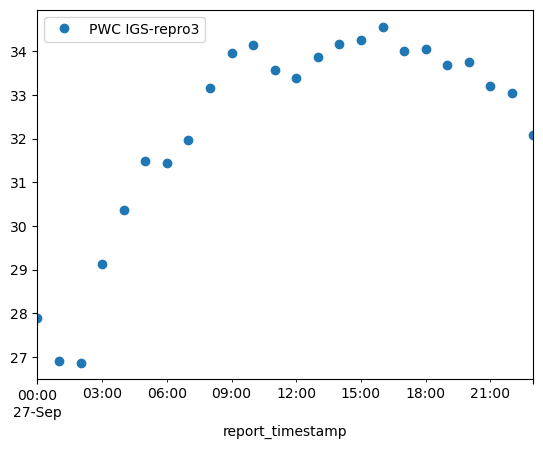

In [8]:
df.loc[df.observed_variable=='precipitable_water_column'].plot(x='report_timestamp',y='observation_value',
                                                                    style='o',label='PWC IGS-repro3')

We can also plot the ERA5 equivalent, interpolated at the observation time and location.

<Axes: xlabel='report_timestamp'>

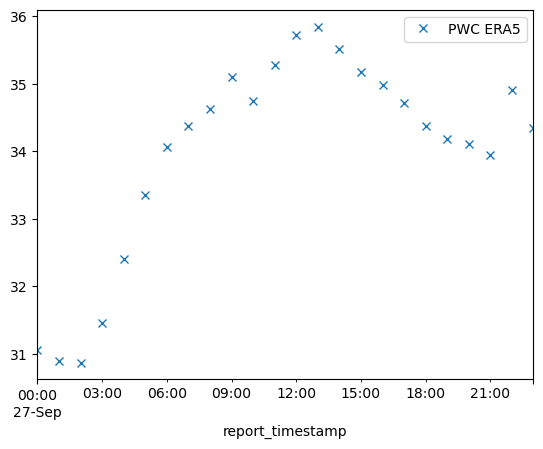

In [9]:
df.loc[df.observed_variable=='precipitable_water_column_era5'].plot(x='report_timestamp',y='observation_value',
                                                                    style='x',label='PWC ERA5')

We can now select an individual report, for example at "2019-09-27 12:00:00". The field to filter is "report_timestamp".

In [10]:
df_report = df.loc[df.report_timestamp == "2019-09-27 12:00:00"]
df_report

,observation_id,report_id,observed_variable,observation_value,units,primary_station_id,height_of_station_above_sea_level,report_timestamp,city,uncertainty_type1,uncertainty_type5,uncertainty_units1,uncertainty_units5,uncertainty_value1,uncertainty_value5,longitude|station_configuration,latitude|station_configuration
index,,,,,,,,,,,,,,,,,
36,b'46435069',b'7',precipitable_water_column,33.389999,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 12:00:00,b'Ajaccio',1,5,b'NA',b'kg m-2',NaN,0.43,8.762608,41.927452
37,b'46435069',b'7',precipitable_water_column_era5,35.730000,b'kg m-2',b'AJAC00FRA',50.080891,2019-09-27 12:00:00,b'Ajaccio',1,5,b'NA',b'NA',NaN,NaN,8.762608,41.927452
38,b'46435069',b'7',zenith_total_delay,2.515000,b'm',b'AJAC00FRA',50.080891,2019-09-27 12:00:00,b'Ajaccio',1,5,b'm',b'NA',0.0011,NaN,8.762608,41.927452


## Arrange the data with one variable per column

But now suppose that we want the data in a variable per column format, with precipitable water column and zenith total delays aligned in distinct columns. For this we need to use the __pivot__ pandas method.

In [11]:
df_bycol_vars = df.pivot(
    columns="observed_variable", 
    values=["observation_value"], 
    index=["report_timestamp"]
)
df_bycol_vars

observation_value                                 \
observed_variable   precipitable_water_column precipitable_water_column_era5   
report_timestamp                                                               
2019-09-27 00:00:00                 27.900000                      31.049999   
2019-09-27 01:00:00                 26.900000                      30.889999   
2019-09-27 02:00:00                 26.870001                      30.870001   
2019-09-27 03:00:00                 29.139999                      31.459999   
2019-09-27 04:00:00                 30.360001                      32.400002   
2019-09-27 05:00:00                 31.480000                      33.349998   
2019-09-27 06:00:00                 31.450001                      34.070000   
2019-09-27 07:00:00                 31.969999                      34.369999   
2019-09-27 08:00:00                 33.160000                      34.630001   
2019-09-27 09:00:00                 33.970001                      35.110001   
2019-09-27 10:00:00                 34.139999                      34.750000   
2019-09-27 11:00:00                 33.580002                      35.279999   
2019-09-27 12:00:00                 33.389999                      35.730000   
2019-09-27 13:00:00                 33.869999                      35.849998   
2019-09-27 14:00:00                 34.180000                      35.520000   
2019-09-27 15:00:00                 34.270000                      35.180000   
2019-09-27 16:00:00                 34.570000                      34.980000   
2019-09-27 17:00:00                 34.000000                      34.709999   
2019-09-27 18:00:00                 34.049999                      34.380001   
2019-09-27 19:00:00                 33.680000                      34.180000   
2019-09-27 20:00:00                 33.759998                      34.110001   
2019-09-27 21:00:00                 33.200001                      33.939999   
2019-09-27 22:00:00                 33.049999                      34.910000   
2019-09-27 23:00:00                 32.080002                      34.340000   

                                        
observed_variable   zenith_total_delay  
report_timestamp                        
2019-09-27 00:00:00             2.4803  
2019-09-27 01:00:00             2.4733  
2019-09-27 02:00:00             2.4728  
2019-09-27 03:00:00             2.4871  
2019-09-27 04:00:00             2.4952  
2019-09-27 05:00:00             2.5023  
2019-09-27 06:00:00             2.5030  
2019-09-27 07:00:00             2.5065  
2019-09-27 08:00:00             2.5144  
2019-09-27 09:00:00             2.5194  
2019-09-27 10:00:00             2.5204  
2019-09-27 11:00:00             2.5164  
2019-09-27 12:00:00             2.5150  
2019-09-27 13:00:00             2.5174  
2019-09-27 14:00:00             2.5185  
2019-09-27 15:00:00             2.5192  
2019-09-27 16:00:00             2.5213  
2019-09-27 17:00:00             2.5186  
2019-09-27 18:00:00             2.5195  
2019-09-27 19:00:00             2.5181  
2019-09-27 20:00:00             2.5186  
2019-09-27 21:00:00             2.5150  
2019-09-27 22:00:00             2.5137  
2019-09-27 23:00:00             2.5076

Pivot will return a dataframe with a __multiindex__ for the columns, which is not confortable to use. Unfortunately there is not an elegant way to fix this. The best way is to use a list comprehension in order to turn the columns from a list of tuples to a list of strings.

In [12]:
df_bycol_vars.columns = ["_".join(cols).replace("observation_value_", "") for cols in df_bycol_vars.columns]
df_bycol_vars

,precipitable_water_column,precipitable_water_column_era5,zenith_total_delay
report_timestamp,,,
2019-09-27 00:00:00,27.900000,31.049999,2.4803
2019-09-27 01:00:00,26.900000,30.889999,2.4733
2019-09-27 02:00:00,26.870001,30.870001,2.4728
2019-09-27 03:00:00,29.139999,31.459999,2.4871
2019-09-27 04:00:00,30.360001,32.400002,2.4952
2019-09-27 05:00:00,31.480000,33.349998,2.5023
2019-09-27 06:00:00,31.450001,34.070000,2.5030
2019-09-27 07:00:00,31.969999,34.369999,2.5065
2019-09-27 08:00:00,33.160000,34.630001,2.5144


Now, in order to plot against the time stamp, we can use set_index, sort_index and then plot. Using automatic pandas subplots, we will get the pressure in the horizontal axis, which is not the most common way to visualize soundings.

array([<Axes: xlabel='report_timestamp'>,
       <Axes: xlabel='report_timestamp'>,
       <Axes: xlabel='report_timestamp'>], dtype=object)

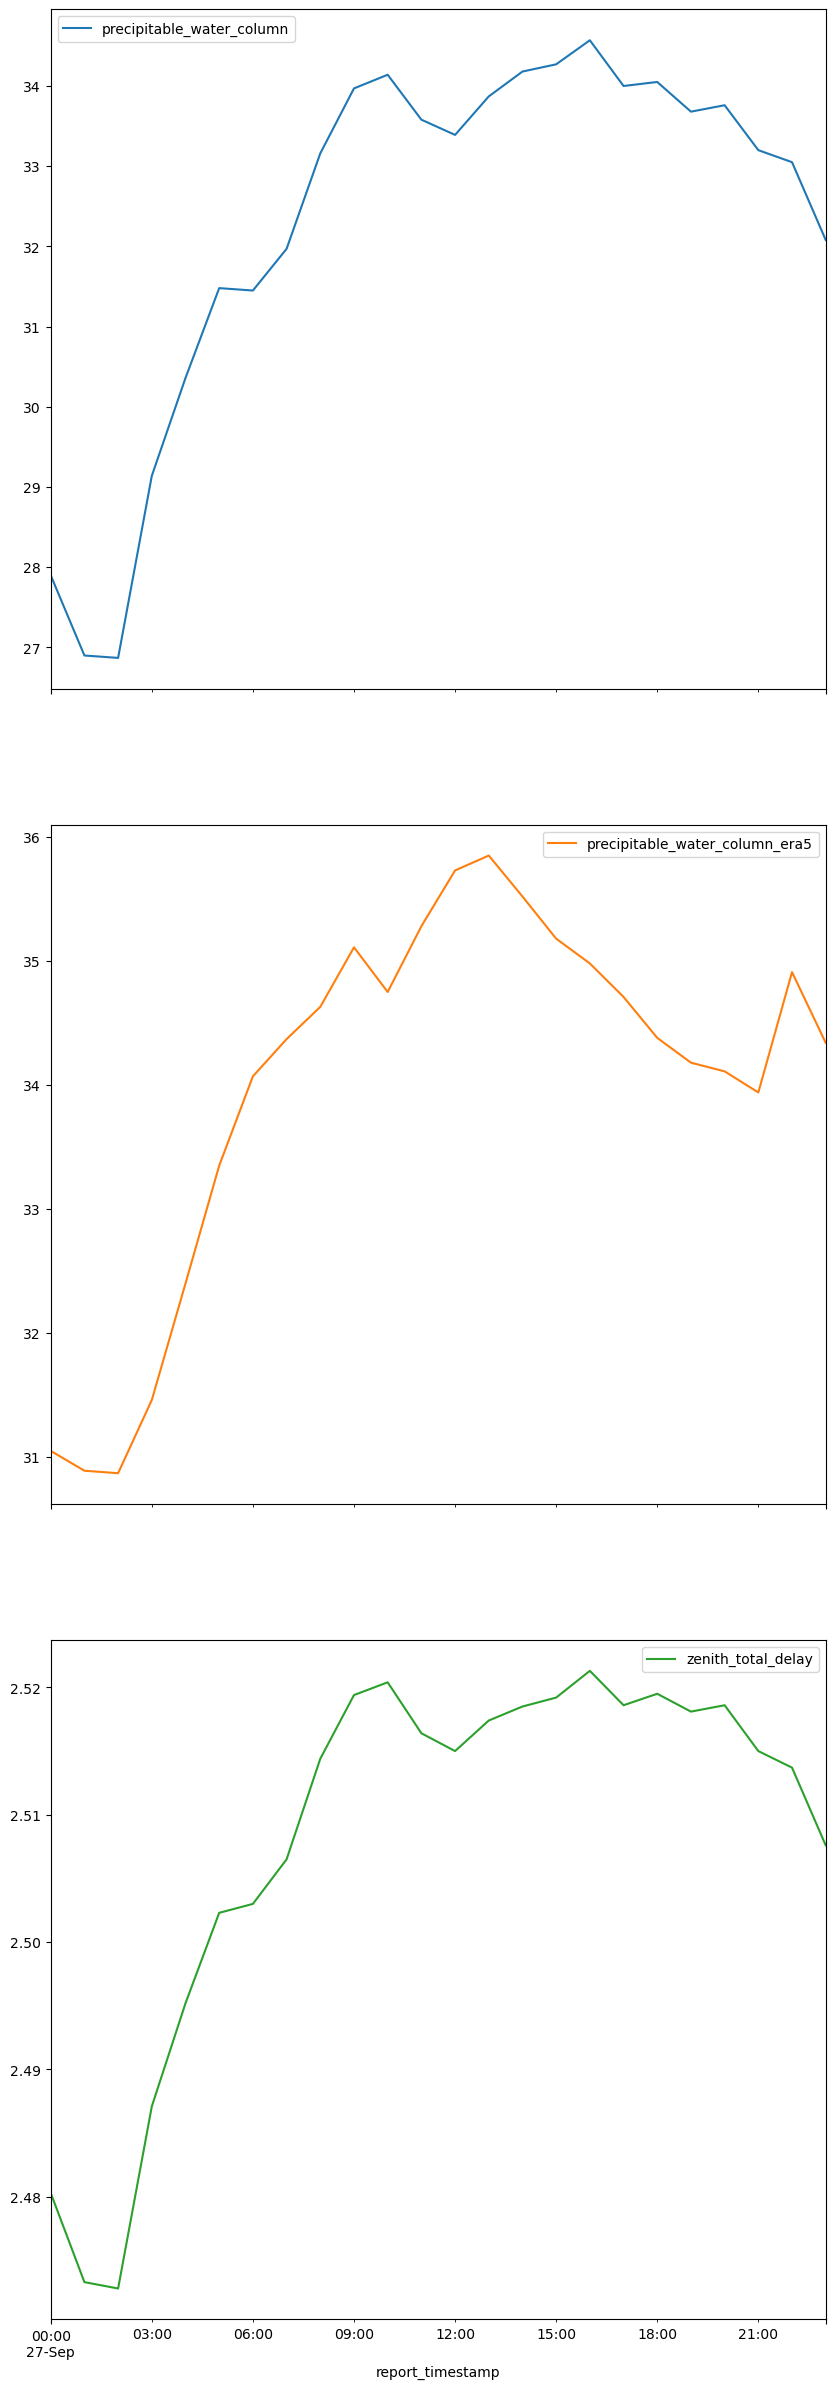

In [13]:
df_bycol_vars_timestamp = df_bycol_vars.sort_index()
df_bycol_vars_timestamp.plot(subplots=True, figsize=(10, 30))

We can get a nicer figure using matplotlib:

3 variables to display


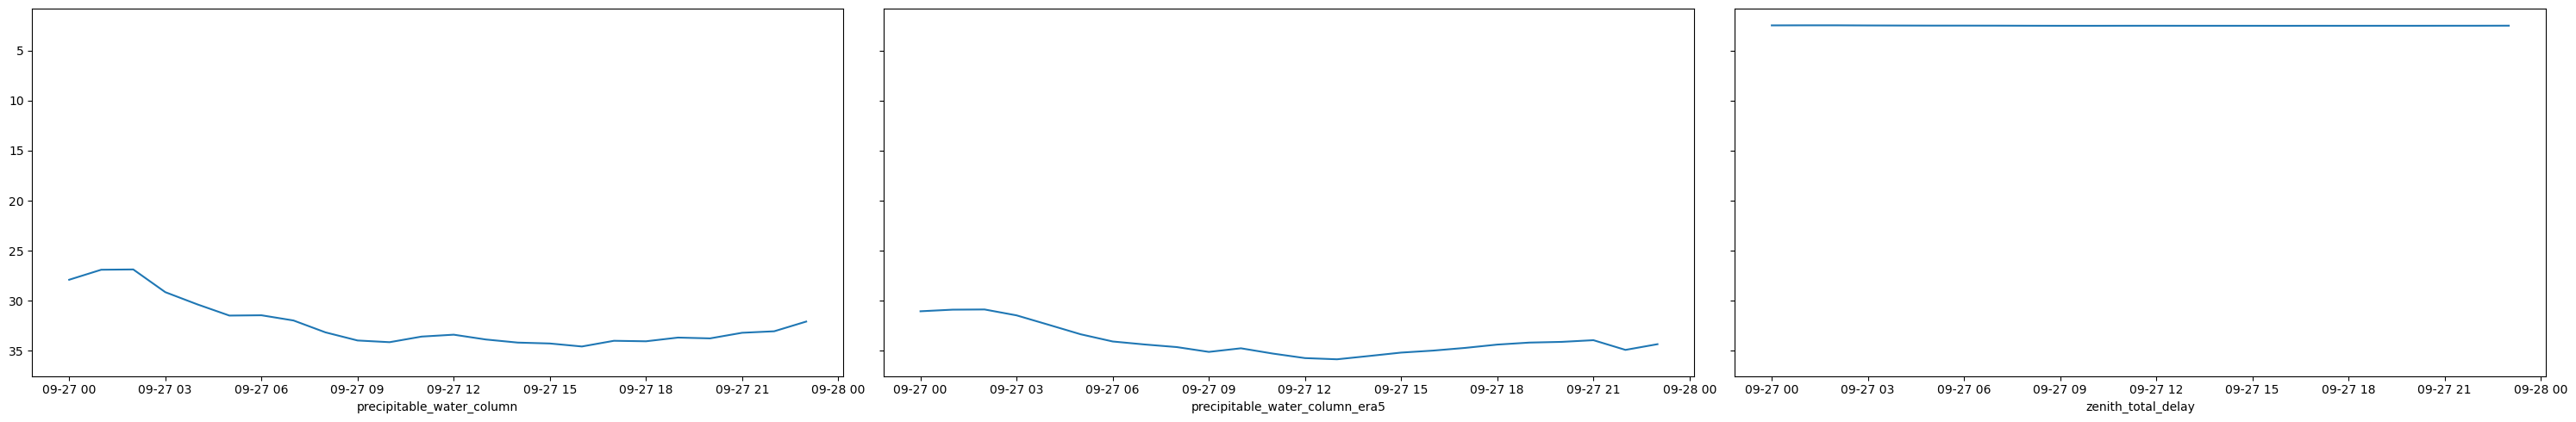

In [14]:
import matplotlib.pyplot as plt

nvars = len(df_bycol_vars_timestamp.columns)
print("{0} variables to display".format(nvars))
fig, axs = plt.subplots(1, nvars, figsize=(30, 5), sharey=True)
timestamps = df_bycol_vars_timestamp.index
axs[0].set_xlabel("Date/time")

for i, var in enumerate(df_bycol_vars_timestamp.columns):
    ax = axs[i]
    ax.plot(timestamps, df_bycol_vars_timestamp[var])
    ax.invert_yaxis()
    ax.set_xlabel(var)

plt.tight_layout()